In [1]:
import import_ipynb

from keras.models import load_model

from control_data import *
from corr_pred import data_corr, pred_days
from make_df import merge_list
from modeling import *

Using TensorFlow backend.
importing Jupyter notebook from control_data.ipynb
importing Jupyter notebook from corr_pred.ipynb
importing Jupyter notebook from make_df.ipynb
importing Jupyter notebook from modeling.ipynb


In [2]:
lg_data = pd.read_csv('data/066570.csv', index_col = 0)
lg_data

,종가,거래량,기관매매량,외국인매매량,외국인보유율
2009-12-04,115500.0,2173892.0,148804.0,441274.0,27.64
2009-12-07,116500.0,1480237.0,-178243.0,455106.0,27.94
2009-12-08,116500.0,1052500.0,-103475.0,254921.0,28.11
2009-12-09,117500.0,1060857.0,-109753.0,138751.0,28.21
2009-12-10,117500.0,1484562.0,-150623.0,70291.0,28.26
...,...,...,...,...,...
2020-01-17,69200.0,464204.0,-89757.0,11089.0,33.77
2020-01-20,71200.0,894609.0,89928.0,249277.0,33.94
2020-01-21,70100.0,379059.0,-30571.0,-17604.0,34.09
2020-01-22,70400.0,546215.0,64709.0,-73675.0,34.08


In [3]:
df = lg_data
corr = data_corr(df, y = -1)
corr

['y: 외국인보유율',
 'x: 종가',
 LinregressResult(slope=0.00019754502625637797, intercept=11.269676308608796, rvalue=0.573299174699053, pvalue=1.9316448402787148e-218, stderr=5.64879696093616e-06)]

In [4]:
x_train, x_test, y_train, y_test = set_data(df)
x_train, x_test, y_train, y_test = set_data(df, test_rate = 0.1)
prices, foreign_rate, p_figs, a_figs = set_data(df, values = True)

In [5]:
model = price_pred_model(save = True, filename = '20.02.04_dropout', lstm = 3)
# model = load_model('data/20.02.04_unfitted.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 2)             40        
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            17152     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

Train on 2016 samples, validate on 225 samples
Epoch 1/30
2016/2016 [==============================] - 93s 46ms/step - loss: 0.1518 - val_loss: 0.0778
Epoch 2/30
2016/2016 [==============================] - 90s 45ms/step - loss: 0.0892 - val_loss: 0.1993
Epoch 3/30
2016/2016 [==============================] - 90s 45ms/step - loss: 0.0774 - val_loss: 0.0947
Epoch 4/30
2016/2016 [==============================] - 90s 45ms/step - loss: 0.0650 - val_loss: 0.0921
Epoch 5/30
2016/2016 [==============================] - 90s 45ms/step - loss: 0.0623 - val_loss: 0.1275
Epoch 6/30
2016/2016 [==============================] - 90s 45ms/step - loss: 0.0519 - val_loss: 0.1451
Epoch 7/30
2016/2016 [==============================] - 90s 44ms/step - loss: 0.0496 - val_loss: 0.1997
Epoch 8/30
2016/2016 [==============================] - 90s 45ms/step - loss: 0.0470 - val_loss: 0.1170
Epoch 9/30
2016/2016 [==============================] - 87s 43ms/step - loss: 0.0418 - val_loss: 0.1701
Epoch 10/30
2016/

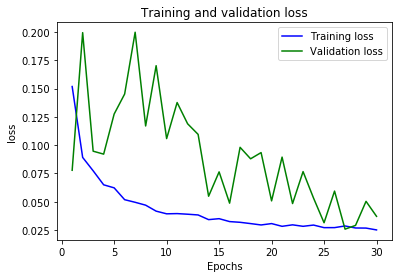

In [6]:
fit = model_fit(
    model, x_train, y_train, val_rate = 0.1, save = True, img_save = True, filename = '20.02.05_dropout', epochs = 30)
fit = load_model('data/20.02.05_dropout_fitted.h5')

In [7]:
train_pred = to_1d_list(fit.predict(x_train))
test_pred = to_1d_list(fit.predict(x_test))

d_train_pred = denormalize(train_pred, p_figs)
d_test_pred = denormalize(test_pred, p_figs)
d_last_pred = pred_days(
    fit, prices, foreign_rate, p_figs, a_figs, corr[2][:2], days = 4)

d_test_pred_added = [d_train_pred[-1]] + d_test_pred + [d_last_pred[0][0]]
d_last_pred = d_last_pred[0]

empty = len(prices) - (len(d_train_pred) + len(d_test_pred))

print(len(d_train_pred), len(d_test_pred_added), empty)

2241 251 10


In [8]:
result_df = merge_list(
    df, empty, prices, d_train_pred, d_test_pred_added, d_last_pred, len(d_test_pred_added)
    )

result_df

,real,trained,tested,pred
2009-12-04,115500.0,NaN,NaN,NaN
2009-12-07,116500.0,NaN,NaN,NaN
2009-12-08,116500.0,NaN,NaN,NaN
2009-12-09,117500.0,NaN,NaN,NaN
2009-12-10,117500.0,NaN,NaN,NaN
...,...,...,...,...
2020-01-22,70400.0,NaN,61290.0,NaN
2020-01-23,69000.0,NaN,61280.0,61280.0
D+1,NaN,NaN,NaN,78560.0
D+2,NaN,NaN,NaN,85310.0


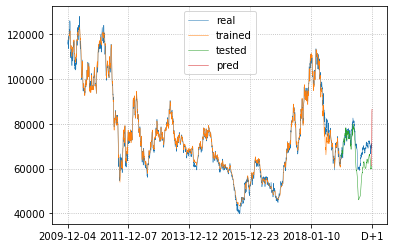

In [9]:
result_df.plot(linewidth = '.5')
plt.grid(ls = ':')
# plt.xticks(np.arange(min(prices), max(prices), step = 0.2))
plt.autoscale(tight = False)

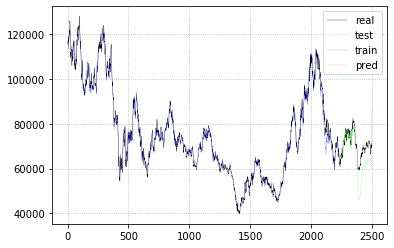

In [10]:
plt.plot(list(result_df[result_df.columns[0]]), 'black', linewidth = '.3')
plt.plot(list(result_df[result_df.columns[2]]), 'lime', linewidth = '.3', alpha = 0.5)
plt.plot(list(result_df[result_df.columns[1]]), 'blue', linewidth = '.3', alpha = 0.5)
plt.plot(list(result_df[result_df.columns[3]]), 'red', linewidth = '.3', alpha = 0.5)
# x축 idx 수정 가능한지?
plt.grid(ls = ':')
plt.legend(['real', 'test', 'train', 'pred'])

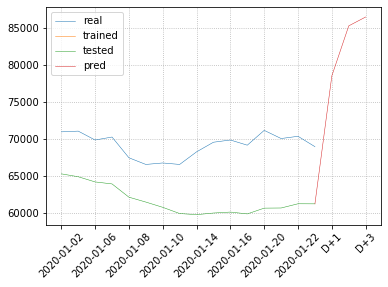

In [11]:
result_df['2019-12.31':].plot(linewidth = '.5')
plt.grid(ls = ':')
# plt.xticks(np.arange(min(prices), max(prices), step = 0.2))
plt.xticks(rotation = 45)
plt.autoscale(tight = False)

In [12]:
pred_days(fit, prices, foreign_rate, p_figs, a_figs, corr[2][:2], days = 100)

([61280.0,
  78560.0,
  85310.0,
  86510.0,
  87290.0,
  87860.0,
  88610.0,
  89410.0,
  89940.0,
  90130.0,
  90060.0,
  90200.0,
  90410.0,
  90660.0,
  90940.0,
  91270.0,
  91620.0,
  91990.0,
  92390.0,
  92820.0,
  93280.0,
  93780.0,
  94320.0,
  94910.0,
  95550.0,
  96240.0,
  96980.0,
  97780.0,
  98630.0,
  99540.0,
  100510.0,
  101540.0,
  102610.0,
  103730.0,
  104880.0,
  106040.0,
  107210.0,
  108360.0,
  109480.0,
  110550.0,
  111560.0,
  112500.0,
  113370.0,
  114160.0,
  114870.0,
  115510.0,
  116070.0,
  116570.0,
  117010.0,
  117400.0,
  117730.0,
  118030.0,
  118280.0,
  118500.0,
  118690.0,
  118860.0,
  119000.0,
  119120.0,
  119230.0,
  119320.0,
  119400.0,
  119470.0,
  119520.0,
  119570.0,
  119610.0,
  119650.0,
  119680.0,
  119710.0,
  119730.0,
  119750.0,
  119770.0,
  119780.0,
  119790.0,
  119800.0,
  119810.0,
  119820.0,
  119820.0,
  119830.0,
  119830.0,
  119840.0,
  119840.0,
  119850.0,
  119850.0,
  119850.0,
  119850.0,
  119850.0